In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import copy
torch.manual_seed(0)
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Load MNIST datasets
trainset_MNIST = torchvision.datasets.MNIST('data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
train_loader_MNIST = DataLoader(trainset_MNIST, batch_size = 256, shuffle = True)

testset_MNIST = torchvision.datasets.MNIST('data', train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_loader_MNIST = DataLoader(testset_MNIST, batch_size = 256, shuffle = True)

In [4]:
class model(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.hide1 = nn.Linear(784, 250)
        self.hide2 = nn.Linear(250, 125)
        self.out = nn.Linear(125, 10)
    
    def forward(self, x):
        x = nn.functional.leaky_relu(self.hide1(x))
        x = nn.functional.leaky_relu(self.hide2(x))
        x = self.out(x)
        return x

In [10]:
loss_fun = nn.CrossEntropyLoss()

def train3(data_loader):
    train_num = 8
    epoch_max = 50
    grad_rec = {}
    loss_rec = {}
    weight_rec = {}
    for num in range(train_num):
        m1 = model().to(device)
        loss = []
        grad = []
        weight = []
        optim = torch.optim.AdamW(m1.parameters(), lr = 0.0008)
        for epoch in tqdm(range(epoch_max)):
            loss_each = 0
            for images, labels in data_loader:
                images, labels = images.to(device).reshape(-1, 28 * 28), labels.to(device)
                predict = m1(images)
                loss_r = loss_fun(predict, labels)
                optim.zero_grad()
                loss_r.backward()
                optim.step()
                loss_each += loss_r.item() / len(data_loader)
            if epoch % 3 == 0:
                weight.append(copy.deepcopy(m1.state_dict()))
                loss.append(loss_each)
                grad_all = 0.0
                for p in m1.parameters():
                    grads = 0.0
                    if p.grad is not None:
                        grads = (p.grad.cpu().data.numpy() ** 2).sum()
                    grad_all += grads
                grad_norm = grad_all ** 0.5
                grad.append(grad_norm)
                
        grad_rec[num] = grad
        loss_rec[num] = loss
        weight_rec[num] = weight
    sample_num = len(weight_rec[0])
    total_sample_num = train_num * sample_num
    feat_num = weight_rec[0][0]['hide1.weight'].cpu().numpy().flatten().shape[0]
    init_PCA = np.zeros((total_sample_num, feat_num)) # Set up initial PCA matrix
    
    for i in range(train_num):
        for j in range(sample_num):
            init_PCA[i * sample_num + j, :] = weight_rec[i][j]['hide1.weight'].flatten().cpu().numpy()
    new_PCA = PCA(n_components = 2).fit_transform(init_PCA)
    
    
    return new_PCA, weight_rec
    


new_PCA, weight_rec = train3(train_loader_MNIST)

100%|██████████| 50/50 [03:44<00:00,  4.49s/it]


In [ ]:
new_PCA

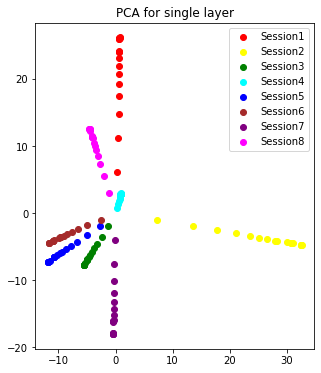

In [8]:
colors = ["red", "yellow", "green", "cyan", "blue", "brown", "purple", "magenta"]
train_num = 8
sample_num = len(weight_rec[0])
total_sample_num = train_num * sample_num
plt.figure(figsize = (5, 6))
for k in range(train_num):
    start = k * sample_num
    end = (k + 1) * sample_num
    plt.scatter(new_PCA[start:end, 0], new_PCA[start:end, 1], color = colors[k], marker = 'o', label = f"Session{k + 1}")
plt.legend()
plt.title('PCA for single layer')
plt.show()
    

In [5]:
loss_fun = nn.CrossEntropyLoss()

def train4(data_loader):
    train_num = 8
    epoch_max = 50
    grad_rec = {}
    loss_rec = {}
    weight_rec = {}
    for num in range(train_num):
        m1 = model().to(device)
        loss = []
        grad = []
        weight = []
        optim = torch.optim.AdamW(m1.parameters(), lr = 0.0008)
        for epoch in tqdm(range(epoch_max)):
            loss_each = 0
            for images, labels in data_loader:
                images, labels = images.to(device).reshape(-1, 28 * 28), labels.to(device)
                predict = m1(images)
                loss_r = loss_fun(predict, labels)
                optim.zero_grad()
                loss_r.backward()
                optim.step()
                loss_each += loss_r.item() / len(data_loader)
            if epoch % 3 == 0:
                weight.append(copy.deepcopy(m1.state_dict()))
                loss.append(loss_each)
                grad_all = 0.0
                for p in m1.parameters():
                    grads = 0.0
                    if p.grad is not None:
                        grads = (p.grad.cpu().data.numpy() ** 2).sum()
                    grad_all += grads
                grad_norm = grad_all ** 0.5
                grad.append(grad_norm)
                
        grad_rec[num] = grad
        loss_rec[num] = loss
        weight_rec[num] = weight
    sample_num = len(weight_rec[0])
    total_sample_num = train_num * sample_num
    feat_num = weight_rec[0][0]['hide1.weight'].cpu().numpy().flatten().shape[0] + weight_rec[0][0]['hide2.weight'].cpu().numpy().flatten().shape[0] + weight_rec[0][0]['out.weight'].cpu().numpy().flatten().shape[0]
    init_PCA = np.zeros((total_sample_num, feat_num)) # Set up initial PCA matrix
    
    for i in range(train_num):
        for j in range(sample_num):
            init_PCA[i * sample_num + j, :] = np.append(weight_rec[i][j]['hide1.weight'].flatten().cpu().numpy(), np.append(weight_rec[i][j]['hide2.weight'].flatten().cpu().numpy(), weight_rec[i][j]['out.weight'].flatten().cpu().numpy()))
    new_PCA = PCA(n_components = 2).fit_transform(init_PCA)
    return new_PCA
    
train4(train_loader_MNIST)

100%|██████████| 50/50 [03:47<00:00,  4.55s/it]


array([[  0.91743732,   7.47129344],
       [  1.53278884,  13.11133298],
       [  1.91349179,  16.82077659],
       [  2.19165701,  19.50506573],
       [  2.36654075,  21.51378138],
       [  2.52127383,  23.04674124],
       [  2.63045639,  24.25915242],
       [  2.75478625,  25.64998093],
       [  2.8440449 ,  26.50830548],
       [  2.87015739,  26.63425757],
       [  2.87185914,  26.71630268],
       [  3.0452927 ,  28.64143219],
       [  3.0548146 ,  28.7406909 ],
       [  3.04900803,  28.69108645],
       [  3.04414372,  28.6517978 ],
       [  3.04022893,  28.62805563],
       [  3.03950664,  28.62288682],
       [  8.88694869,  -1.92255715],
       [ 15.60162403,  -3.45542587],
       [ 20.01069671,  -4.49390252],
       [ 23.32181434,  -5.28391124],
       [ 25.80377289,  -5.85985849],
       [ 27.53516753,  -6.28037802],
       [ 29.05070293,  -6.64126873],
       [ 30.61027902,  -7.00590921],
       [ 30.98563986,  -7.09068867],
       [ 32.74210968,  -7.45585816],
 

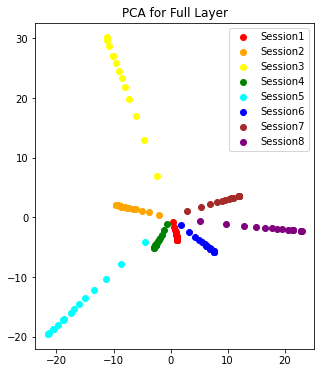

In [11]:
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "brown", "purple", "magenta"]
train_num = 8
sample_num = len(weight_rec[0])
total_sample_num = train_num * sample_num
plt.figure(figsize = (5, 6))
for k in range(train_num):
    start = k * sample_num
    end = (k + 1) * sample_num
    plt.scatter(new_PCA[start:end, 0], new_PCA[start:end, 1], color = colors[k], marker = 'o', label = f"Session{k + 1}")
plt.legend()
plt.title('PCA for Full Layer')
plt.show()

In [12]:
loss_fun = nn.CrossEntropyLoss()

def train5(data_loader):
    epoch_max = 50
    m1 = model().to(device)
    loss = []
    grad = []
    optim = torch.optim.AdamW(m1.parameters(), lr = 0.0008)
    for epoch in tqdm(range(epoch_max)):
        loss_each = 0
        for images, labels in data_loader:
            images, labels = images.to(device).reshape(-1, 28 * 28), labels.to(device)
            predict = m1(images)
            loss_r = loss_fun(predict, labels)
            optim.zero_grad()
            loss_r.backward()
            optim.step()
            loss.append(loss_r.item())
            loss_each += loss_r.item() / len(data_loader)
            grad_all = 0.0
            for p in m1.parameters():
                grads = 0.0
                if p.grad is not None:
                    grads = (p.grad.cpu().data.numpy() ** 2).sum()
                grad_all += grads
            grad_norm = grad_all ** 0.5
            grad.append(grad_norm)
    return loss, grad

loss, grad = train5(train_loader_MNIST)

100%|██████████| 50/50 [04:11<00:00,  5.03s/it]


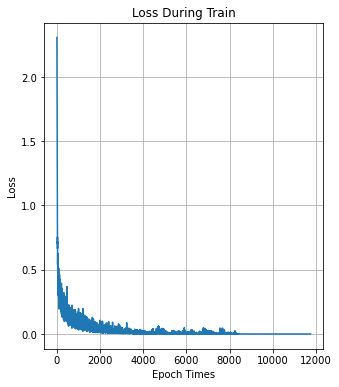

In [26]:
plt.figure(figsize = (5, 6))
plt.plot(loss)
plt.grid(True)
plt.title('Loss During Train')
plt.xlabel("Epoch Times")
plt.ylabel("Loss")
plt.show()

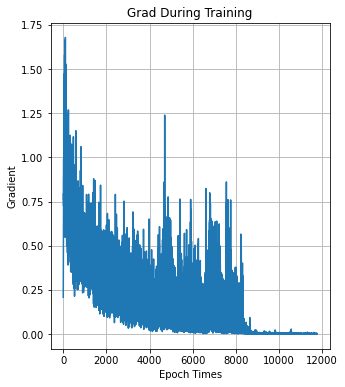

In [25]:
plt.figure(figsize = (5, 6))
plt.plot(grad)
plt.grid(True)
plt.title('Grad During Training')
plt.xlabel("Epoch Times")
plt.ylabel("Gradient")
plt.show()

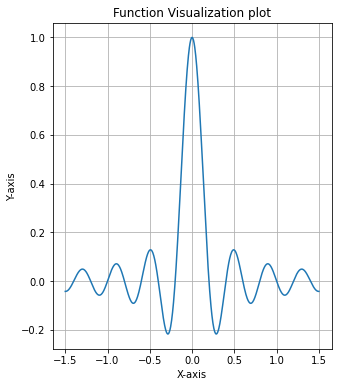

In [16]:
x1 = torch.unsqueeze(torch.linspace(-1.5, 1.5, 800), dim = 1)
y1 = torch.sin(5 * np.pi * x1) / (5 * np.pi * x1) 
#Visualization of first function
plt.figure(figsize = (5, 6))
plt.plot(x1, y1)
plt.title("Function Visualization plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()

In [17]:
class model_1(nn.Module):
    def __init__(self, ):
        super(model_1, self).__init__()
        self.hide1 = nn.Linear(1, 5) #hidden layer 1..
        self.hide2 = nn.Linear(5, 10)
        self.hide3 = nn.Linear(10, 10)
        self.hide4 = nn.Linear(10, 10)
        self.hide5 = nn.Linear(10, 10)
        self.hide6 = nn.Linear(10, 10)
        self.hide7 = nn.Linear(10, 5)
        self.out = nn.Linear(5, 1) #output layer
    
    def forward(self, x):
        x = nn.functional.leaky_relu(self.hide1(x))
        x = nn.functional.leaky_relu(self.hide2(x))
        x = nn.functional.leaky_relu(self.hide3(x))
        x = nn.functional.leaky_relu(self.hide4(x))
        x = nn.functional.leaky_relu(self.hide5(x))
        x = nn.functional.leaky_relu(self.hide6(x))
        x = nn.functional.leaky_relu(self.hide7(x))
        x = self.out(x)
        return x

In [20]:
loss_fun = torch.nn.MSELoss()
epoch_max = 20000
model_1 = model_1()
optim_m1 = torch.optim.AdamW(model_1.parameters(), lr = 0.001, weight_decay = 1e-4)
def train(model, x, y, optimizer):
    model_loss = []
    model_grad = []
    for epoch in range(epoch_max):
        predict = model(x)
        loss = loss_fun(predict, y) #Mean squared error loss function
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model_loss.append(loss.item())
        grad_all = 0.0
        for p in model_1.parameters():
            grads = 0.0
            if p.grad is not None:
                grads = (p.grad.cpu().data.numpy() ** 2).sum()
            grad_all += grads
        grad_norm = grad_all ** 0.5
        model_grad.append(grad_norm)
    return model_loss, model_grad

model_loss, model_grad = train(model_1, x1, y1, optim_m1)



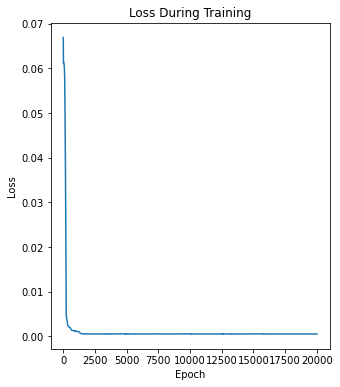

In [22]:
plt.figure(figsize=(5,6))
plt.plot(model_loss)
plt.title('Loss During Training')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

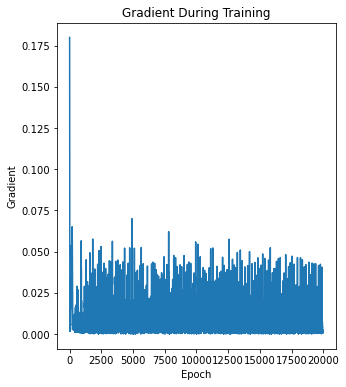

In [27]:
plt.figure(figsize=(5,6))
plt.plot(model_grad)
plt.title('Gradient During Training')
plt.xlabel("Epoch")
plt.ylabel("Gradient")
plt.show()

Epoch: 750/750: 100%|██████████| 750/750 [00:22<00:00, 34.07it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:23<00:00, 31.48it/s]


loss: [0.0013599046040326356, 0.0013599046040326356, 0.0013599045807495714, 0.0013599046505987644, 0.0013599045807495714, 0.0013599046273157001, 0.0013599046040326356, 0.0013599046273157001, 0.0013599045807495714, 0.0013599046273157001, 0.0013599046040326356, 0.0013599045574665069, 0.0013599046040326356, 0.0013599045807495714, 0.0013599046738818287, 0.0013599045807495714, 0.0013599046505987644, 0.0013599046273157001, 0.0013599046505987644, 0.0013599046040326356, 0.0013599045574665069, 0.0013599046040326356, 0.0013599045807495714, 0.0013599046273157001, 0.0013599045341834426, 0.0013599045807495714, 0.0013599045807495714, 0.0013599046040326356, 0.0013599046040326356, 0.0013599045807495714, 0.0013599045574665069, 0.0013599045574665069, 0.0013599046040326356, 0.0013599045574665069, 0.0013599045574665069, 0.0013599045341834426, 0.0013599045807495714, 0.0013599045574665069, 0.0013599045341834426, 0.0013599046040326356, 0.0013599045341834426, 0.0013599045807495714, 0.0013599045807495714, 0.00

Epoch: 750/750: 100%|██████████| 750/750 [00:18<00:00, 41.49it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:22<00:00, 33.74it/s]


loss: [0.0011889525223523379, 0.0011889524292200803, 0.001188952405937016, 0.0011889524292200803, 0.0011889521963894367, 0.0011889521731063724, 0.0011889521265402436, 0.0011889521265402436, 0.0011889519868418575, 0.001188951963558793, 0.0011889519402757287, 0.0011889518704265357], gradient: [0.008713176473975182, 0.0072314441204071045, 0.005556102376431227, 0.009502775967121124, 0.008918490260839462, 0.008777259849011898, 0.009342034347355366, 0.008713212795555592, 0.009747007861733437, 0.009227283298969269, 0.008791559375822544, 0.009885587729513645], minimal_ratio: [0.18848896026611328, 0.18814118206501007, 0.18953225016593933, 0.18761953711509705, 0.1888367235660553, 0.18953225016593933, 0.186576247215271, 0.18814118206501007, 0.18988001346588135, 0.18535906076431274, 0.19057555496692657, 0.18414188921451569]


Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 35.12it/s]


loss: [0.0008739156764931977, 0.0008739097393117845], gradient: [0.009091716259717941, 0.009764524176716805], minimal_ratio: [0.26517125964164734, 0.2662145793437958]


Epoch: 750/750: 100%|██████████| 750/750 [00:18<00:00, 41.04it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:16<00:00, 46.21it/s]


loss: [0.0012858683243393899, 0.0012858683010563254], gradient: [0.007574857212603092, 0.009601748548448086], minimal_ratio: [0.21300643682479858, 0.2131803184747696]


Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 35.73it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:30<00:00, 24.94it/s]


loss: [0.0009682493982836604, 0.0009682493982836604, 0.0009682494099251926, 0.0009682494099251926, 0.0009682493866421283, 0.0009682493633590639, 0.0009682493982836604, 0.0009682493982836604, 0.0009682494215667248, 0.0009682493982836604, 0.0009682493866421283, 0.0009682494215667248, 0.0009682493866421283, 0.0009682493982836604, 0.0009682494099251926, 0.000968249375000596, 0.000968249375000596, 0.000968249375000596, 0.0009682493633590639, 0.0009682494215667248, 0.0009682493866421283, 0.0009682494215667248, 0.0009682493982836604, 0.0009682493866421283, 0.0009682493982836604, 0.0009682493633590639, 0.000968249375000596, 0.000968249375000596, 0.000968249375000596, 0.0009682494332082569, 0.0009682493517175316, 0.0009682493982836604, 0.000968249375000596, 0.0009682493633590639, 0.0009682493633590639, 0.0009682494215667248, 0.0009682494099251926, 0.0009682493982836604, 0.0009682493866421283, 0.0009682493982836604, 0.000968249375000596, 0.0009682493982836604, 0.000968249375000596, 0.00096824935

Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 35.01it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:47<00:00, 15.75it/s]


loss: [0.0007766999304294586, 0.0007766999304294586, 0.0007766999653540552, 0.0007766999304294586, 0.0007766999653540552, 0.0007766999653540552, 0.0007766999653540552, 0.0007766999653540552, 0.0007766999653540552, 0.0007766999653540552, 0.0007766999653540552, 0.000776699953712523, 0.0007766999769955873, 0.0007766999886371195, 0.0007766999769955873, 0.0007766999420709908, 0.000776699953712523, 0.0007766999653540552, 0.000776699953712523, 0.000776699953712523, 0.0007766999769955873, 0.0007766999653540552, 0.0007767000002786517, 0.000776699953712523, 0.0007766999653540552, 0.0007766999420709908, 0.0007766999420709908, 0.000776699953712523, 0.0007766999653540552, 0.0007766999653540552, 0.000776699953712523, 0.000776699953712523, 0.0007766999420709908, 0.0007766999653540552, 0.0007766999653540552, 0.0007766999653540552, 0.0007766999653540552, 0.0007766999653540552, 0.0007766999420709908, 0.000776699953712523, 0.0007766999886371195, 0.0007766999653540552, 0.000776699953712523, 0.000776699965

Epoch: 750/750: 100%|██████████| 750/750 [00:22<00:00, 33.99it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:26<00:00, 27.91it/s]


loss: [0.0009477087995037436, 0.0009477087412960827, 0.0009477086015976966, 0.0009477085550315678, 0.0009477084735408425, 0.0009477083804085851, 0.0009477082756347954, 0.0009477081592194736, 0.0009477081475779414, 0.0009477080660872161, 0.0009477079496718943, 0.0009477079147472978, 0.0009477078798227012, 0.0009477078332565725, 0.0009477074723690748, 0.0009477074956521392, 0.0009477074490860105, 0.0009477073792368174, 0.0009477073210291565, 0.0009477072744630277, 0.0009477071347646415, 0.0009477071580477059, 0.0009477071347646415, 0.0009477070299908519, 0.0009477068786509335, 0.0009477068670094013, 0.0009477067505940795, 0.0009477066923864186, 0.0009477066458202898, 0.0009477066691033542, 0.0009477066341787577, 0.0009477065759710968, 0.0009477065526880324, 0.0009477064828388393, 0.0009477063198573887, 0.0009477060637436807, 0.0009477060404606164, 0.0009477058192715049, 0.0009477058541961014, 0.0009477057727053761, 0.0009477057494223118, 0.0009477057843469084, 0.0009477055515162647, 0.00

Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.15it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 37.51it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.54it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:26<00:00, 28.76it/s]


loss: [0.0011698328191414476, 0.0011698328657075764, 0.0011698328889906406, 0.0011698328424245119, 0.001169832795858383, 0.0011698328657075764, 0.0011698328657075764, 0.0011698328424245119, 0.0011698328191414476, 0.0011698327725753188, 0.001169832795858383, 0.0011698327492922545, 0.0011698327725753188, 0.0011698327027261258, 0.0011698327492922545, 0.0011698327027261258, 0.0011698327027261258, 0.001169832656159997, 0.00116983272600919, 0.0011698326328769327, 0.0011698326328769327, 0.00116983272600919, 0.0011698326794430613, 0.0011698326794430613, 0.0011698326328769327, 0.001169832586310804, 0.0011698326095938682, 0.0011698325630277394, 0.0011698326095938682, 0.0011698325397446752, 0.0011698326095938682, 0.0011698324931785464, 0.0011698325164616109, 0.001169832469895482, 0.001169832469895482, 0.001169832469895482, 0.0011698324931785464, 0.001169832469895482, 0.001169832469895482, 0.0011698324931785464, 0.0011698325164616109, 0.0011698324931785464, 0.0011698324466124176, 0.001169832400046

Epoch: 750/750: 100%|██████████| 750/750 [00:42<00:00, 17.74it/s]


loss: [0.0011731453007087112, 0.0011731452774256467, 0.0011731452541425824, 0.0011731453007087112, 0.0011731452774256467, 0.0011731452541425824, 0.0011731453007087112, 0.0011731453007087112, 0.0011731452774256467, 0.0011731453007087112, 0.0011731453007087112, 0.0011731453007087112, 0.0011731452308595181, 0.0011731452774256467, 0.0011731452774256467, 0.0011731452541425824, 0.0011731452774256467, 0.0011731452308595181, 0.0011731452541425824, 0.0011731453007087112, 0.0011731452541425824, 0.0011731452541425824, 0.0011731452774256467, 0.0011731453007087112, 0.0011731452774256467, 0.0011731452774256467, 0.0011731453007087112, 0.0011731453007087112, 0.0011731452541425824, 0.0011731452774256467, 0.0011731452774256467, 0.0011731453007087112, 0.0011731452774256467, 0.0011731452308595181, 0.0011731452541425824, 0.0011731452308595181, 0.0011731453007087112, 0.0011731452541425824, 0.0011731452774256467, 0.0011731453007087112, 0.0011731452774256467, 0.0011731452774256467, 0.0011731452774256467, 0.00

Epoch: 750/750: 100%|██████████| 750/750 [00:26<00:00, 28.54it/s]


loss: [0.001132800686173141, 0.001132800686173141, 0.001132800686173141, 0.001132800686173141, 0.001132800686173141, 0.0011328006628900766, 0.001132800686173141, 0.001132800686173141, 0.0011328007094562054, 0.0011328006628900766, 0.0011328007094562054, 0.0011328006628900766, 0.0011328007094562054, 0.0011328007094562054, 0.0011328006628900766, 0.0011328006396070123, 0.0011328007327392696, 0.001132800686173141, 0.0011328006396070123, 0.0011328005930408835, 0.0011328006396070123, 0.0011328006628900766, 0.0011328006628900766, 0.0011328005930408835, 0.0011328006396070123, 0.0011328007327392696, 0.0011328006396070123, 0.0011328006163239478, 0.0011328006396070123, 0.0011328006163239478, 0.0011328006396070123, 0.0011328006163239478, 0.0011328006396070123, 0.0011328005697578193, 0.0011328005464747548, 0.0011328006396070123, 0.0011328006396070123, 0.0011328005697578193, 0.0011328005464747548, 0.0011328005697578193, 0.0011328005231916905, 0.0011328005464747548, 0.0011328005464747548, 0.0011328005

Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.15it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.22it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.74it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:22<00:00, 33.74it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:34<00:00, 21.82it/s]


loss: [0.0016702036606147884, 0.0016702036373317242, 0.0016702036373317242, 0.0016702036373317242, 0.0016702036373317242, 0.0016702036140486599, 0.0016702036140486599, 0.0016702036140486599, 0.0016702036373317242, 0.0016702035907655954, 0.0016702035674825311, 0.0016702035907655954, 0.0016702036140486599, 0.0016702036373317242, 0.0016702036140486599, 0.0016702036606147884, 0.0016702036140486599, 0.0016702035674825311, 0.001670203683897853, 0.0016702036140486599, 0.0016702036606147884, 0.0016702036606147884, 0.0016702036373317242, 0.001670203683897853, 0.0016702035907655954, 0.0016702036140486599, 0.0016702036373317242, 0.0016702036373317242, 0.0016702036606147884, 0.0016702035907655954, 0.0016702036373317242, 0.0016702036373317242, 0.0016702036140486599, 0.0016702035674825311, 0.0016702036140486599, 0.0016702036140486599, 0.0016702036373317242, 0.0016702036140486599, 0.0016702036140486599, 0.0016702035674825311, 0.0016702035674825311, 0.0016702035907655954, 0.0016702036606147884, 0.0016

Epoch: 750/750: 100%|██████████| 750/750 [00:17<00:00, 42.62it/s]


loss: [0.0012930945958942175, 0.0012930946191772818, 0.0012930945726111532, 0.0012930945726111532, 0.0012930945958942175, 0.0012930945726111532, 0.0012930945958942175, 0.0012930945726111532, 0.0012930945726111532, 0.0012930945260450244, 0.0012930945493280887, 0.0012930945958942175, 0.0012930945726111532, 0.0012930945493280887, 0.0012930945493280887, 0.0012930945958942175, 0.0012930946424603463], gradient: [0.006511298008263111, 0.009755642153322697, 0.009241714142262936, 0.008194582536816597, 0.009862640872597694, 0.008967376314103603, 0.006418842356652021, 0.004363414831459522, 0.008572978898882866, 0.005946720484644175, 0.0039258552715182304, 0.007535623386502266, 0.004911382216960192, 0.009052692912518978, 0.006429275032132864, 0.00729853380471468, 0.009496407583355904], minimal_ratio: [0.21161536872386932, 0.21039818227291107, 0.2112676054239273, 0.20709441602230072, 0.208659365773201, 0.2131803184747696, 0.21039818227291107, 0.20935489237308502, 0.2133542001247406, 0.2067466527223

Epoch: 750/750: 100%|██████████| 750/750 [00:17<00:00, 43.11it/s]


loss: [0.0015085411258041858, 0.0015085411723703146, 0.0015085412189364434, 0.0015085412189364434, 0.0015085411956533789, 0.0015085411723703146, 0.0015085411956533789, 0.0015085411723703146, 0.0015085411956533789, 0.0015085411956533789, 0.0015085412189364434, 0.0015085411490872503, 0.0015085412422195077, 0.0015085412189364434, 0.0015085412422195077, 0.0015085411723703146, 0.0015085411956533789, 0.0015085411723703146, 0.0015085412189364434, 0.0015085411956533789, 0.0015085411723703146, 0.0015085411723703146, 0.0015085411956533789, 0.0015085411956533789, 0.0015085411723703146, 0.0015085412189364434, 0.0015085411956533789, 0.0015085412189364434, 0.0015085411723703146], gradient: [0.0085946936160326, 0.005739329382777214, 0.006692252587527037, 0.008667325600981712, 0.009497491642832756, 0.009205379523336887, 0.009200497530400753, 0.009689363650977612, 0.002001604065299034, 0.0086098937317729, 0.00511200400069356, 0.007671271916478872, 0.005401032045483589, 0.0075950464233756065, 0.00484278

Epoch: 750/750: 100%|██████████| 750/750 [00:27<00:00, 26.83it/s]


loss: [0.001340217050164938, 0.0013402170035988093, 0.0013402170035988093, 0.0013402170734480023, 0.0013402170268818736, 0.0013402169803157448, 0.0013402169803157448, 0.0013402169803157448, 0.0013402170268818736, 0.0013402169803157448, 0.0013402169570326805, 0.0013402169337496162, 0.0013402170035988093, 0.0013402169803157448, 0.0013402169104665517, 0.0013402169570326805, 0.0013402169803157448, 0.0013402169337496162, 0.0013402169570326805, 0.0013402168871834875, 0.001340216863900423, 0.0013402168173342944, 0.0013402168173342944, 0.00134021679405123, 0.001340216863900423, 0.0013402168406173587, 0.00134021679405123, 0.0013402168173342944, 0.0013402167707681656, 0.00134021679405123, 0.0013402167707681656, 0.0013402167707681656, 0.0013402167474851011, 0.0013402167009189726, 0.0013402167474851011, 0.0013402167707681656, 0.0013402167242020369, 0.0013402167242020369, 0.001340216677635908, 0.0013402167009189726, 0.001340216677635908, 0.0013402166543528438, 0.0013402166310697793, 0.0013402166310

Epoch: 750/750: 100%|██████████| 750/750 [00:24<00:00, 30.52it/s]


loss: [0.0011016029398888349, 0.0011016028933227063, 0.0011016029398888349, 0.0011016028700396418, 0.0011016028933227063, 0.0011016028700396418, 0.0011016029166057706, 0.0011016029166057706, 0.0011016028700396418, 0.0011016029166057706, 0.0011016028467565775, 0.0011016028700396418, 0.0011016028700396418, 0.0011016029166057706, 0.0011016029398888349, 0.0011016028700396418, 0.0011016028700396418, 0.0011016028700396418, 0.0011016029166057706, 0.0011016028933227063, 0.0011016028933227063, 0.0011016028700396418, 0.0011016028933227063, 0.0011016028700396418, 0.0011016029166057706, 0.0011016029166057706, 0.0011016029398888349, 0.0011016028700396418, 0.0011016029166057706, 0.001101602823473513, 0.0011016029398888349, 0.0011016028467565775, 0.0011016028933227063, 0.0011016028700396418, 0.0011016028700396418, 0.0011016029398888349, 0.0011016028467565775, 0.0011016028933227063, 0.0011016029166057706, 0.0011016029166057706, 0.0011016029166057706, 0.0011016028700396418, 0.0011016028700396418, 0.001

Epoch: 750/750: 100%|██████████| 750/750 [00:16<00:00, 44.80it/s]


loss: [0.001292433962225914, 0.0012924339855089784, 0.0012924339389428496, 0.001292433962225914, 0.0012924340087920427, 0.001292433962225914, 0.0012924339855089784, 0.0012924339855089784, 0.0012924339855089784, 0.0012924339855089784, 0.001292433962225914, 0.0012924339855089784, 0.0012924340087920427, 0.001292433962225914, 0.0012924340320751072, 0.0012924339855089784, 0.0012924340320751072, 0.001292433962225914, 0.001292433962225914, 0.0012924340087920427, 0.0012924339855089784, 0.0012924339855089784, 0.0012924339855089784, 0.0012924340087920427], gradient: [0.009397045709192753, 0.00898265652358532, 0.0078056445345282555, 0.009197904728353024, 0.007593720220029354, 0.00996200181543827, 0.009045365266501904, 0.008397240191698074, 0.008806882426142693, 0.007491860073059797, 0.009508754126727581, 0.009663292206823826, 0.00983625091612339, 0.009606972336769104, 0.008524986915290356, 0.008979965932667255, 0.008610396645963192, 0.009091309271752834, 0.0063445232808589935, 0.00986611284315586

Epoch: 750/750: 100%|██████████| 750/750 [00:22<00:00, 33.03it/s]


loss: [0.0009286693762987852, 0.0009286693762987852, 0.0009286693879403174, 0.0009286693530157208, 0.000928669364657253, 0.0009286693762987852, 0.0009286693762987852, 0.0009286693879403174, 0.0009286693762987852, 0.0009286693762987852, 0.000928669364657253, 0.0009286693762987852, 0.0009286693995818496, 0.0009286693413741887, 0.0009286694345064461, 0.0009286693879403174, 0.0009286693762987852, 0.0009286693762987852, 0.0009286693413741887, 0.0009286693530157208, 0.0009286693762987852, 0.0009286693879403174, 0.0009286693413741887, 0.0009286693995818496, 0.000928669364657253, 0.0009286693762987852, 0.0009286693762987852, 0.0009286693879403174, 0.0009286693879403174, 0.000928669364657253, 0.0009286693762987852, 0.0009286693879403174, 0.0009286693530157208, 0.0009286693762987852, 0.0009286693995818496, 0.0009286693879403174, 0.0009286693995818496, 0.0009286693879403174, 0.0009286693995818496, 0.0009286693995818496, 0.000928669364657253, 0.0009286693762987852, 0.0009286693879403174, 0.0009286

Epoch: 750/750: 100%|██████████| 750/750 [00:24<00:00, 31.08it/s]


loss: [0.0013220890192314982, 0.0013220889959484339, 0.0013220889726653696, 0.001322088949382305, 0.0013220890192314982, 0.0013220889959484339, 0.001322088949382305, 0.001322088949382305, 0.0013220889726653696, 0.0013220889028161763, 0.0013220889959484339, 0.0013220889260992408, 0.0013220889260992408, 0.0013220889260992408, 0.0013220889260992408, 0.0013220889260992408, 0.0013220889260992408, 0.0013220888329669833, 0.0013220888562500478, 0.0013220889028161763, 0.0013220888562500478, 0.0013220888562500478, 0.0013220888329669833, 0.0013220887631177902, 0.0013220888562500478, 0.0013220888562500478, 0.001322088809683919, 0.0013220887864008545, 0.001322088809683919, 0.0013220888329669833, 0.0013220887864008545, 0.0013220887864008545, 0.0013220888329669833, 0.0013220887631177902, 0.001322088809683919, 0.0013220887631177902, 0.0013220888329669833, 0.0013220887165516614, 0.001322088739834726, 0.001322088739834726, 0.001322088739834726, 0.001322088739834726, 0.001322088739834726, 0.0013220887631

Epoch: 750/750: 100%|██████████| 750/750 [00:28<00:00, 26.62it/s]


loss: [0.000490302947582677, 0.0004903029242996126, 0.0004903029359411449, 0.000490302947582677, 0.0004903029301203787, 0.000490302947582677, 0.0004903029184788465, 0.0004903029359411449, 0.0004903029650449753, 0.0004903029534034431, 0.0004903029592242091, 0.000490302947582677, 0.0004903029417619109, 0.0004903029417619109, 0.0004903029242996126, 0.0004903029534034431, 0.000490302947582677, 0.0004903029417619109, 0.000490302947582677, 0.0004903029359411449, 0.0004903029359411449, 0.0004903029359411449, 0.0004903029301203787, 0.0004903029534034431, 0.0004903029592242091, 0.0004903029301203787, 0.000490302947582677, 0.0004903029359411449, 0.0004903029534034431, 0.0004903029359411449, 0.000490302947582677, 0.0004903029359411449, 0.0004903029359411449, 0.0004903029417619109, 0.0004903029417619109, 0.000490302947582677, 0.0004903029301203787, 0.0004903029417619109, 0.000490302947582677, 0.0004903029417619109, 0.0004903029359411449, 0.0004903029534034431, 0.0004903029359411449, 0.000490302953

Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.97it/s]


loss: [0.0009291731286793948, 0.0009291731170378625, 0.0009291731752455234, 0.0009291732218116522, 0.00092917321017012, 0.0009291731868870557, 0.0009291732218116522, 0.0009291732218116522, 0.0009291731985285878, 0.0009291731752455234, 0.0009291731985285878, 0.0009291731868870557, 0.0009291731868870557, 0.00092917321017012, 0.0009291731868870557, 0.00092917321017012, 0.00092917321017012, 0.0009291732218116522, 0.00092917321017012, 0.0009291731985285878, 0.00092917321017012, 0.00092917321017012, 0.0009291731868870557, 0.0009291731985285878, 0.00092917321017012, 0.0009291731868870557, 0.0009291731985285878, 0.00092917321017012, 0.0009291731985285878, 0.0009291731985285878, 0.0009291731752455234, 0.0009291731868870557, 0.0009291731985285878, 0.0009291731752455234, 0.0009291731752455234, 0.0009291731752455234, 0.0009291731985285878, 0.0009291731868870557, 0.0009291731752455234, 0.0009291731868870557, 0.0009291731752455234, 0.0009291732334531843, 0.0009291731868870557, 0.0009291731868870557,

Epoch: 750/750: 100%|██████████| 750/750 [00:15<00:00, 48.27it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 36.75it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 37.77it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:39<00:00, 18.89it/s]


loss: [0.0010022895294241607, 0.0010022895294241607, 0.0010022895410656929, 0.0010022895759902895, 0.001002289552707225, 0.0010022895759902895, 0.0010022895177826286, 0.0010022895876318216, 0.0010022895410656929, 0.0010022895876318216, 0.0010022895294241607, 0.0010022895410656929, 0.0010022895061410964, 0.0010022895992733538, 0.0010022895410656929, 0.0010022895294241607, 0.0010022895410656929, 0.0010022895177826286, 0.0010022895410656929, 0.0010022895410656929, 0.001002289552707225, 0.0010022895177826286, 0.0010022895294241607, 0.0010022895759902895, 0.0010022895643487574, 0.0010022895643487574, 0.0010022895876318216, 0.0010022895294241607, 0.0010022894712164998, 0.001002289552707225, 0.0010022895643487574, 0.0010022895643487574, 0.0010022895643487574, 0.0010022895410656929, 0.001002289552707225, 0.0010022895643487574, 0.0010022895876318216, 0.0010022895410656929, 0.001002289494499564, 0.0010022895410656929, 0.0010022895294241607, 0.0010022895294241607, 0.0010022895410656929, 0.0010022

Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 36.62it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 36.19it/s]


loss: [0.0008625425281934441, 0.0008625425049103797, 0.0008625425281934441, 0.0008625425281934441, 0.0008625425281934441, 0.0008625425514765083, 0.0008625425165519118, 0.0008625425514765083], gradient: [0.009401775896549225, 0.009988892823457718, 0.008608818054199219, 0.009697994217276573, 0.009986350312829018, 0.009637691080570221, 0.008207147940993309, 0.009978343732655048], minimal_ratio: [0.22796034812927246, 0.2352634221315384, 0.2267431765794754, 0.24082767963409424, 0.23369848728179932, 0.23456789553165436, 0.24952182173728943, 0.2291775345802307]


Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 36.91it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:23<00:00, 31.77it/s]


loss: [0.0015712718246504664, 0.0015712718246504664, 0.0015712718479335309, 0.001571271801367402, 0.0015712718479335309, 0.0015712718712165951, 0.001571271801367402, 0.0015712718246504664, 0.0015712718944996596, 0.0015712718479335309, 0.001571271801367402, 0.0015712718246504664, 0.0015712718246504664, 0.001571271801367402, 0.001571271801367402, 0.0015712718246504664, 0.0015712718479335309, 0.0015712718712165951, 0.0015712718944996596, 0.0015712718246504664, 0.0015712718246504664, 0.0015712718479335309, 0.0015712718479335309, 0.001571271801367402, 0.0015712718479335309, 0.0015712717780843378, 0.0015712718246504664, 0.0015712717780843378, 0.0015712718246504664, 0.0015712718246504664, 0.0015712718479335309, 0.0015712718246504664, 0.0015712718712165951, 0.0015712718479335309, 0.0015712718479335309, 0.0015712718479335309, 0.0015712718246504664, 0.0015712718479335309, 0.001571271801367402, 0.0015712718479335309, 0.001571271801367402, 0.0015712718246504664, 0.0015712718712165951, 0.0015712718

Epoch: 750/750: 100%|██████████| 750/750 [00:23<00:00, 32.16it/s]


loss: [0.0013174262596294284, 0.0013174262829124927, 0.0013174263061955572, 0.0013174262829124927, 0.0013174262596294284, 0.0013174262829124927, 0.0013174263061955572, 0.0013174263061955572, 0.0013174262829124927, 0.0013174262829124927, 0.0013174262829124927, 0.0013174263294786215, 0.0013174262596294284, 0.0013174263527616858, 0.0013174263527616858, 0.0013174262596294284, 0.0013174263061955572, 0.0013174263061955572, 0.0013174262829124927, 0.0013174263294786215, 0.0013174262596294284, 0.0013174263061955572, 0.0013174262596294284, 0.0013174262829124927, 0.0013174263061955572, 0.0013174263061955572, 0.0013174263061955572, 0.0013174263294786215, 0.0013174262829124927, 0.0013174262829124927, 0.0013174263294786215, 0.0013174263061955572, 0.0013174263061955572, 0.0013174263061955572, 0.0013174263061955572, 0.0013174262596294284, 0.0013174262596294284, 0.001317426236346364, 0.0013174263294786215, 0.0013174263294786215, 0.0013174262829124927, 0.0013174262829124927, 0.0013174263061955572, 0.001

Epoch: 750/750: 100%|██████████| 750/750 [00:41<00:00, 18.07it/s]


loss: [0.0010353010380640625, 0.001035301061347127, 0.001035301061347127, 0.0010353011079132558, 0.0010353010147809982, 0.001035301061347127, 0.0010353010497055949, 0.0010353010380640625, 0.0010353010846301913, 0.001035301061347127, 0.001035301061347127, 0.0010353010729886591, 0.0010353010147809982, 0.001035301061347127, 0.0010353011079132558, 0.001035301061347127, 0.001035301061347127, 0.001035301061347127, 0.001035301061347127, 0.0010353010846301913, 0.0010353011079132558, 0.001035301119554788, 0.0010353010729886591, 0.0010353010497055949, 0.0010353010380640625, 0.0010353010962717234, 0.0010353010380640625, 0.0010353010497055949, 0.001035301061347127, 0.0010353010497055949, 0.0010353010846301913, 0.0010353010497055949, 0.0010353010729886591, 0.001035301061347127, 0.0010353010846301913, 0.0010353010846301913, 0.0010353010147809982, 0.0010353010380640625, 0.001035301061347127, 0.0010353010497055949, 0.0010353010147809982, 0.001035301061347127, 0.001035301061347127, 0.001035301061347127

Epoch: 750/750: 100%|██████████| 750/750 [00:26<00:00, 28.24it/s]


loss: [0.0012095510493963957, 0.0012095509795472027, 0.0012095510261133312, 0.00120955107267946, 0.001209551002830267, 0.0012095510493963957, 0.0012095510493963957, 0.0012095510959625245, 0.00120955107267946, 0.001209551002830267, 0.0012095510261133312, 0.00120955107267946, 0.00120955107267946, 0.00120955107267946, 0.0012095510493963957, 0.0012095510261133312, 0.0012095510261133312, 0.00120955107267946, 0.001209551002830267, 0.001209551002830267, 0.0012095510261133312, 0.0012095510261133312, 0.0012095510493963957, 0.0012095510261133312, 0.0012095510493963957, 0.00120955107267946, 0.001209551002830267, 0.0012095510261133312, 0.0012095510493963957, 0.0012095510261133312, 0.0012095510261133312, 0.0012095510261133312, 0.00120955107267946, 0.0012095510493963957, 0.0012095510493963957, 0.00120955107267946, 0.00120955107267946, 0.00120955107267946, 0.00120955107267946, 0.0012095510261133312, 0.0012095510261133312, 0.0012095510493963957, 0.00120955107267946, 0.0012095510493963957, 0.0012095510

Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 35.48it/s]


loss: [0.0009444664232432842, 0.0009444663533940912, 0.0009444663417525589, 0.0009444663301110268, 0.0009444663417525589, 0.0009444663417525589, 0.0009444663184694946, 0.0009444663068279624, 0.0009444662951864302, 0.000944466283544898, 0.000944466283544898, 0.0009444662602618337, 0.0009444662369787693, 0.0009444662369787693, 0.0009444662253372371, 0.000944466155488044, 0.000944466155488044], gradient: [0.008271262980997562, 0.007632140535861254, 0.00981283001601696, 0.009989766404032707, 0.008655400946736336, 0.008429987356066704, 0.009859280660748482, 0.009630518034100533, 0.007992742583155632, 0.008417882956564426, 0.00783240795135498, 0.00884578749537468, 0.008497986011207104, 0.00984230451285839, 0.00921135675162077, 0.009371068328619003, 0.009506875649094582], minimal_ratio: [0.2931663990020752, 0.2863849699497223, 0.297513484954834, 0.292644739151001, 0.2909059226512909, 0.29229697585105896, 0.29386192560195923, 0.2996000647544861, 0.2950791120529175, 0.292644739151001, 0.2922969

Epoch: 750/750: 100%|██████████| 750/750 [00:34<00:00, 21.69it/s]


loss: [0.001038033585064113, 0.0010380336316302419, 0.001038033585064113, 0.001038033585064113, 0.001038033585064113, 0.001038033585064113, 0.0010380335967056452, 0.0010380335384979843, 0.001038033585064113, 0.0010380336316302419, 0.0010380336316302419, 0.001038033585064113, 0.001038033573422581, 0.0010380335617810488, 0.0010380336083471776, 0.0010380336083471776, 0.0010380336083471776, 0.0010380336316302419, 0.0010380336316302419, 0.001038033585064113, 0.0010380336083471776, 0.0010380336083471776, 0.0010380336083471776, 0.0010380336083471776, 0.0010380335617810488, 0.0010380336549133061, 0.0010380336316302419, 0.0010380336083471776, 0.0010380335617810488, 0.0010380336083471776, 0.0010380336199887097, 0.0010380336083471776, 0.0010380335967056452, 0.0010380336083471776, 0.0010380336316302419, 0.0010380336083471776, 0.0010380335967056452, 0.0010380336083471776, 0.0010380336316302419, 0.0010380336316302419, 0.0010380336083471776, 0.001038033585064113, 0.0010380335967056452, 0.001038033608

Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.16it/s]


loss: [0.0009122756076976657, 0.0009122756426222622, 0.0009122756193391979, 0.0009122756426222622, 0.0009122756426222622, 0.0009122756542637944, 0.0009122756426222622, 0.0009122756193391979, 0.0009122756542637944, 0.0009122756309807301, 0.0009122756193391979, 0.0009122756309807301, 0.0009122756426222622, 0.0009122756542637944, 0.0009122756309807301, 0.0009122756193391979, 0.0009122756309807301, 0.0009122756309807301, 0.0009122755960561335, 0.0009122756426222622, 0.0009122756659053266, 0.0009122756309807301, 0.0009122756426222622, 0.0009122756542637944, 0.0009122756309807301, 0.0009122756426222622, 0.0009122756426222622, 0.0009122755960561335, 0.0009122756426222622, 0.0009122756309807301, 0.0009122756542637944, 0.0009122756426222622, 0.0009122756309807301, 0.0009122756426222622, 0.0009122756426222622, 0.0009122756076976657, 0.0009122756193391979, 0.0009122756542637944, 0.0009122756426222622, 0.0009122756076976657, 0.0009122756542637944, 0.0009122756542637944], gradient: [0.0070249605923

Epoch: 750/750: 100%|██████████| 750/750 [00:29<00:00, 25.56it/s]


loss: [0.001682280981913209, 0.0016822809586301446, 0.0016822810284793377, 0.0016822810051962734, 0.0016822810051962734, 0.0016822810051962734, 0.0016822809586301446, 0.0016822809353470801, 0.001682280981913209, 0.001682281051762402, 0.001682280981913209, 0.0016822809586301446, 0.0016822809586301446, 0.001682280981913209, 0.001682280981913209, 0.0016822809586301446, 0.0016822810284793377, 0.0016822810051962734, 0.0016822809586301446, 0.0016822810051962734, 0.0016822810051962734, 0.0016822809586301446, 0.0016822809353470801, 0.0016822809586301446, 0.0016822809586301446, 0.0016822810051962734, 0.0016822810051962734, 0.0016822809586301446, 0.0016822809120640159, 0.0016822810051962734, 0.001682280981913209, 0.001682280981913209, 0.0016822809586301446, 0.0016822810051962734, 0.0016822809586301446, 0.001682280981913209, 0.0016822809120640159, 0.001682280981913209, 0.0016822809586301446, 0.001682280981913209, 0.0016822810051962734, 0.001682280981913209, 0.0016822809353470801, 0.00168228098191

Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 36.48it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 36.69it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:22<00:00, 33.03it/s]


loss: [0.0012629502918571234, 0.0012629502918571234, 0.0012629502918571234, 0.0012629502918571234, 0.0012629503151401877, 0.001262950268574059, 0.0012629503384232522, 0.0012629502918571234, 0.0012629503617063165, 0.0012629503151401877, 0.0012629503151401877, 0.0012629502918571234, 0.0012629502918571234, 0.0012629502918571234, 0.0012629503151401877, 0.0012629503384232522, 0.0012629502918571234, 0.0012629503151401877, 0.001262950268574059, 0.0012629503384232522, 0.0012629502452909946, 0.001262950268574059, 0.0012629502918571234, 0.0012629502918571234, 0.0012629503384232522, 0.0012629503151401877, 0.0012629502918571234, 0.0012629502918571234, 0.0012629502918571234, 0.001262950268574059, 0.001262950268574059, 0.001262950268574059, 0.0012629502918571234, 0.0012629503384232522, 0.0012629502918571234, 0.0012629502918571234, 0.0012629503151401877, 0.0012629503151401877, 0.0012629503617063165, 0.0012629502918571234, 0.0012629503384232522, 0.0012629502452909946, 0.0012629502918571234, 0.00126295

Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 37.62it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 35.96it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:14<00:00, 52.14it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:32<00:00, 23.44it/s]


loss: [0.0009395275614224374, 0.0009395275614224374, 0.0009395275847055018, 0.0009395275497809053, 0.0009395275730639697, 0.000939527538139373, 0.0009395275730639697, 0.0009395275614224374, 0.0009395275497809053, 0.0009395275614224374, 0.000939527538139373, 0.000939527538139373, 0.0009395275497809053, 0.0009395275497809053, 0.000939527538139373, 0.0009395275847055018, 0.000939527538139373, 0.0009395275847055018, 0.0009395275963470339, 0.0009395275614224374, 0.0009395275847055018, 0.0009395275614224374, 0.0009395275497809053, 0.0009395275730639697, 0.0009395275497809053, 0.0009395275847055018, 0.0009395275614224374, 0.0009395275497809053, 0.0009395275730639697, 0.0009395275730639697, 0.0009395275847055018, 0.0009395275497809053, 0.0009395275614224374, 0.000939527538139373, 0.0009395275730639697, 0.0009395275614224374, 0.000939527538139373, 0.000939527538139373, 0.0009395275730639697, 0.0009395275264978409, 0.0009395275614224374, 0.0009395275148563087, 0.0009395275847055018, 0.0009395275

Epoch: 750/750: 100%|██████████| 750/750 [00:14<00:00, 50.56it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:40<00:00, 18.39it/s]


loss: [0.0005459084175527095, 0.0005459080333821475, 0.0005459076957777143, 0.0005459076026454567, 0.0005459075910039246, 0.0005459075793623925, 0.0005459076026454567, 0.000545907614286989, 0.0005459075793623925, 0.0005459075910039246, 0.000545907614286989, 0.0005459075677208602, 0.0005459076026454567, 0.0005459076259285211, 0.0005459075677208602, 0.0005459075910039246, 0.0005459075793623925, 0.000545907614286989, 0.0005459076026454567, 0.0005459075910039246, 0.000545907614286989, 0.000545907614286989, 0.0005459075910039246, 0.0005459076026454567, 0.0005459076026454567, 0.000545907614286989, 0.0005459075910039246, 0.000545907614286989, 0.0005459075910039246, 0.000545907614286989, 0.0005459075910039246, 0.0005459075910039246, 0.0005459076026454567, 0.000545907614286989, 0.0005459075910039246, 0.0005459076026454567, 0.000545907614286989, 0.0005459075910039246, 0.000545907614286989, 0.0005459076026454567, 0.0005459075910039246, 0.0005459075910039246, 0.0005459076026454567, 0.0005459075793

Epoch: 750/750: 100%|██████████| 750/750 [00:18<00:00, 40.50it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:38<00:00, 19.49it/s]


loss: [0.0010528102866373956, 0.0010528102749958635, 0.0010528102982789278, 0.0010528102749958635, 0.0010528103215619923, 0.0010528103448450565, 0.001052810251712799, 0.0010528102982789278, 0.0010528103215619923, 0.0010528103215619923, 0.0010528102749958635, 0.0010528102982789278, 0.0010528102749958635, 0.0010528103215619923, 0.0010528103215619923, 0.0010528102982789278, 0.0010528103448450565, 0.0010528103215619923, 0.0010528103215619923, 0.0010528102749958635, 0.0010528102866373956, 0.0010528102866373956, 0.0010528102982789278, 0.0010528103448450565, 0.0010528103215619923, 0.0010528103215619923, 0.0010528102749958635, 0.00105281030992046, 0.0010528102982789278, 0.0010528103448450565, 0.0010528102982789278, 0.0010528102749958635, 0.001052810251712799, 0.0010528102982789278, 0.0010528102982789278, 0.001052810251712799, 0.0010528102749958635, 0.0010528103215619923, 0.0010528102982789278, 0.0010528102866373956, 0.0010528102749958635, 0.0010528102982789278, 0.0010528102982789278, 0.0010528

Epoch: 750/750: 100%|██████████| 750/750 [00:34<00:00, 21.58it/s]


loss: [0.001093731657601893, 0.0010937315644696354, 0.0010937315179035067, 0.0010937314713373781, 0.001093731285072863, 0.00109373121522367, 0.0010937312385067345, 0.0010937311686575412, 0.00109373121522367, 0.0010937310755252839, 0.001093730959109962, 0.001093730889260769, 0.0010937308659777045, 0.0010937308659777045, 0.0010937307728454472, 0.0010937307495623827, 0.0010937305400148035, 0.0010937304701656102, 0.001093730446882546, 0.0010937304701656102, 0.0010937304003164172, 0.0010937303071841598, 0.0010937302839010953, 0.001093730190768838, 0.0010937301674857735, 0.0010937300976365805, 0.0010937300743535162, 0.001093730004504323, 0.001093730004504323, 0.0010937299812212586, 0.0010937298415228725, 0.001093729748390615, 0.0010937297716736793, 0.0010937296552583574, 0.0010937296552583574, 0.0010937295388430356, 0.0010937294457107783, 0.0010937294689938426, 0.001093729306012392, 0.0010937291895970701, 0.0010937291895970701, 0.0010937291430309416, 0.001093729049898684, 0.00109372893348336

Epoch: 750/750: 100%|██████████| 750/750 [00:33<00:00, 22.06it/s]


loss: [0.0016955347964540124, 0.0016955347498878836, 0.0016955347964540124, 0.0016955347266048193, 0.0016955347033217548, 0.0016955347731709481, 0.0016955347498878836, 0.0016955347498878836, 0.0016955347964540124, 0.0016955347033217548, 0.0016955347731709481, 0.0016955347731709481, 0.0016955347731709481, 0.0016955347964540124, 0.0016955347266048193, 0.0016955347964540124, 0.0016955348197370767, 0.0016955347964540124, 0.0016955347266048193, 0.0016955347266048193, 0.0016955347033217548, 0.0016955347964540124, 0.0016955347266048193, 0.0016955347033217548, 0.0016955347731709481, 0.0016955347731709481, 0.0016955347731709481, 0.0016955347033217548, 0.0016955347498878836, 0.0016955347498878836, 0.0016955347266048193, 0.0016955348197370767, 0.0016955347498878836, 0.0016955347266048193, 0.0016955347964540124, 0.0016955347498878836, 0.0016955347731709481, 0.0016955347498878836, 0.0016955347731709481, 0.0016955347964540124, 0.0016955347731709481, 0.0016955347033217548, 0.0016955347266048193, 0.00

Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 38.55it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:38<00:00, 19.53it/s]


loss: [0.0005955159896984697, 0.0005955159780569374, 0.0005955160013400018, 0.0005955159896984697, 0.0005955159780569374, 0.0005955159664154053, 0.0005955159780569374, 0.0005955159896984697, 0.0005955159896984697, 0.0005955159780569374, 0.0005955159896984697, 0.0005955159896984697, 0.0005955160013400018, 0.0005955159896984697, 0.0005955159780569374, 0.0005955159780569374, 0.0005955160013400018, 0.000595516012981534, 0.0005955160013400018, 0.0005955160013400018, 0.000595516012981534, 0.0005955159896984697, 0.0005955159780569374, 0.0005955159780569374, 0.0005955159664154053, 0.0005955159780569374, 0.0005955160013400018, 0.0005955159896984697, 0.0005955159896984697, 0.0005955160013400018, 0.0005955159896984697, 0.0005955159896984697, 0.0005955159664154053, 0.0005955159664154053, 0.0005955160013400018, 0.0005955160013400018, 0.0005955159896984697, 0.0005955160013400018, 0.0005955160013400018, 0.0005955159780569374, 0.0005955159896984697, 0.0005955159896984697, 0.0005955159780569374, 0.0005

Epoch: 750/750: 100%|██████████| 750/750 [00:31<00:00, 23.93it/s]


loss: [0.0011247830465435983, 0.0011247830698266625, 0.0011247830232605338, 0.001124782976694405, 0.0011247829999774695, 0.0011247829999774695, 0.0011247829999774695, 0.0011247829999774695, 0.0011247830698266625, 0.0011247829999774695, 0.0011247829999774695, 0.0011247829534113407, 0.0011247830232605338, 0.0011247829999774695, 0.0011247830465435983, 0.0011247830232605338, 0.0011247829999774695, 0.0011247829999774695, 0.0011247830465435983, 0.0011247830465435983, 0.0011247830232605338, 0.0011247830698266625, 0.0011247830232605338, 0.0011247829999774695, 0.0011247830465435983, 0.0011247830232605338, 0.0011247829650528729, 0.0011247830232605338, 0.001124782976694405, 0.0011247830465435983, 0.0011247830465435983, 0.001124782976694405, 0.001124782976694405, 0.0011247830465435983, 0.0011247830232605338, 0.0011247829999774695, 0.001124782976694405, 0.0011247829999774695, 0.0011247830232605338, 0.0011247830232605338, 0.0011247829999774695, 0.0011247830465435983, 0.0011247829883359373, 0.0011247

Epoch: 750/750: 100%|██████████| 750/750 [00:27<00:00, 26.87it/s]


loss: [0.0016236887080594898, 0.0016236887080594898, 0.001623688731342554, 0.0016236887080594898, 0.0016236887080594898, 0.001623688661493361, 0.0016236886382102965, 0.001623688731342554, 0.0016236886847764253, 0.001623688661493361, 0.001623688661493361, 0.0016236886847764253, 0.0016236887080594898, 0.0016236887546256184, 0.001623688731342554, 0.0016236887080594898, 0.0016236886847764253, 0.0016236887080594898, 0.0016236886847764253, 0.0016236887080594898, 0.0016236887546256184, 0.0016236887080594898, 0.0016236886847764253, 0.001623688731342554, 0.0016236887080594898, 0.0016236887080594898, 0.0016236886847764253, 0.0016236886847764253, 0.001623688661493361, 0.0016236887080594898, 0.0016236886847764253, 0.0016236887546256184, 0.0016236887080594898, 0.0016236886847764253, 0.0016236886847764253, 0.0016236887080594898, 0.0016236886847764253, 0.001623688661493361, 0.001623688661493361, 0.0016236887546256184, 0.0016236887080594898, 0.0016236886847764253, 0.0016236887546256184, 0.001623688754

Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 37.24it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 37.01it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 36.54it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:18<00:00, 41.60it/s]


loss: [0.0013419512659311294, 0.0013419513124972582, 0.0013419513357803225, 0.0013419512426480651, 0.001341951359063387, 0.0013419513357803225, 0.0013419513357803225, 0.001341951289214194, 0.001341951289214194, 0.001341951289214194, 0.001341951289214194, 0.001341951289214194, 0.0013419513357803225, 0.0013419513124972582, 0.0013419512426480651, 0.001341951289214194, 0.001341951289214194], gradient: [0.007924373261630535, 0.009565332904458046, 0.008372673764824867, 0.005117218475788832, 0.009469165466725826, 0.005764998961240053, 0.005226388573646545, 0.00803434569388628, 0.0070890444330871105, 0.009940233081579208, 0.0038752404507249594, 0.006586448289453983, 0.008947229944169521, 0.005232783500105143, 0.00936147477477789, 0.006955181714147329, 0.005517187993973494], minimal_ratio: [0.03373326361179352, 0.03355938196182251, 0.033037733286619186, 0.03268996626138687, 0.03286384791135788, 0.03355938196182251, 0.03373326361179352, 0.034776560962200165, 0.033037733286619186, 0.0326899662613

Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 37.01it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.36it/s]


loss: [0.0011581606697291136, 0.0011581606464460491, 0.001158160576596856, 0.0011581604601815342, 0.001158160367049277, 0.0011581602972000836, 0.0011581602972000836, 0.0011581600876525045, 0.0011581599246710539, 0.0011581598548218608, 0.0011581597616896033, 0.0011581597151234745, 0.0011581590631976723, 0.0011581590166315435, 0.0011581589467823505, 0.0011581584112718701, 0.001158158457837999, 0.0011581584345549344, 0.0011581583647057414, 0.0011581582482904195, 0.0011581581085920334, 0.001158157968893647, 0.0011581578757613898, 0.0011581577360630035, 0.0011581576662138104, 0.0011581572936847806, 0.0011581571772694588, 0.00115815713070333, 0.0011581570841372013, 0.0011581568047404288, 0.001158156618475914, 0.0011581565253436566, 0.0011581563157960773, 0.0011581561062484979], gradient: [0.009266078472137451, 0.009436306543648243, 0.009704201482236385, 0.009226932190358639, 0.009690792299807072, 0.009541213512420654, 0.009531036019325256, 0.0088344756513834, 0.008984758518636227, 0.00935128

Epoch: 750/750: 100%|██████████| 750/750 [00:18<00:00, 40.10it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:20<00:00, 36.90it/s]


loss: [0.0010424301261082291, 0.0010424301726743579, 0.0010424301493912936, 0.0010424301959574222, 0.0010424301493912936, 0.0010424301261082291, 0.0010424301726743579, 0.0010424301493912936, 0.0010424301493912936, 0.0010424301261082291, 0.0010424301610328258, 0.00104243018431589, 0.0010424301493912936, 0.0010424301726743579, 0.0010424301726743579, 0.0010424301261082291, 0.00104243018431589, 0.0010424301493912936, 0.0010424301261082291, 0.0010424301377497613, 0.0010424301493912936, 0.0010424301493912936, 0.0010424301493912936, 0.0010424301493912936, 0.0010424301493912936, 0.0010424301261082291, 0.0010424301726743579, 0.0010424301261082291, 0.0010424301261082291, 0.0010424301261082291, 0.0010424301493912936, 0.0010424301726743579], gradient: [0.004302304238080978, 0.00309351016767323, 0.00824396125972271, 0.008750026114284992, 0.00874948501586914, 0.007314586546272039, 0.007621206343173981, 0.007095885928720236, 0.008986380882561207, 0.00860959105193615, 0.009772191755473614, 0.007352268

Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.55it/s]


loss: [0.0015374261885881424, 0.0015374261187389494, 0.0015374261420220137, 0.0015374261187389494, 0.0015374261187389494, 0.001537426165305078, 0.001537426165305078, 0.0015374261187389494, 0.0015374261187389494, 0.0015374261420220137, 0.0015374260721728206, 0.0015374261187389494, 0.0015374261420220137, 0.0015374261420220137, 0.0015374261187389494, 0.0015374261420220137, 0.0015374260954558849, 0.0015374261187389494, 0.0015374260954558849, 0.001537426165305078, 0.0015374261187389494, 0.0015374261187389494, 0.0015374261187389494, 0.001537426165305078, 0.0015374260721728206, 0.0015374261187389494, 0.001537426165305078, 0.0015374261420220137, 0.0015374261420220137, 0.0015374261885881424, 0.0015374261187389494, 0.0015374261420220137, 0.0015374260954558849, 0.0015374261187389494, 0.0015374260954558849, 0.0015374261420220137, 0.0015374260721728206, 0.001537426165305078, 0.0015374261420220137, 0.0015374260954558849, 0.0015374261187389494, 0.0015374261187389494, 0.001537426165305078, 0.001537426

Epoch: 750/750: 100%|██████████| 750/750 [00:18<00:00, 39.52it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:27<00:00, 27.54it/s]


loss: [0.0015453847125172615, 0.0015453846659511327, 0.0015453847590833902, 0.0015453846426680684, 0.0015453847590833902, 0.0015453846659511327, 0.0015453846659511327, 0.0015453846892341972, 0.0015453846426680684, 0.0015453846892341972, 0.0015453846892341972, 0.0015453846426680684, 0.0015453846659511327, 0.0015453846426680684, 0.0015453846659511327, 0.0015453846892341972, 0.0015453846426680684, 0.0015453846426680684, 0.0015453847125172615, 0.0015453846426680684, 0.0015453846892341972, 0.0015453846426680684, 0.0015453846892341972, 0.0015453846892341972, 0.0015453846659511327, 0.001545384735800326, 0.0015453847125172615, 0.0015453846659511327, 0.0015453846892341972, 0.0015453846426680684, 0.0015453846659511327, 0.0015453847125172615, 0.0015453847125172615, 0.0015453846659511327, 0.0015453846892341972, 0.0015453847125172615, 0.001545384735800326, 0.001545384735800326, 0.0015453846659511327, 0.0015453846659511327, 0.0015453846892341972, 0.0015453846659511327, 0.0015453846892341972, 0.00154

Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 38.23it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 38.31it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 37.70it/s]


loss: [0.0014430865412577987, 0.001443086564540863, 0.0014430865878239274, 0.0014430865412577987, 0.0014430865412577987, 0.0014430865412577987, 0.001443086564540863, 0.0014430866111069917, 0.001443086564540863, 0.0014430865412577987, 0.001443086564540863, 0.0014430865878239274, 0.0014430865878239274, 0.0014430866111069917, 0.0014430865412577987, 0.001443086564540863, 0.0014430865412577987, 0.001443086564540863, 0.001443086564540863, 0.0014430865412577987, 0.0014430865878239274, 0.0014430865412577987, 0.001443086564540863, 0.0014430866111069917, 0.001443086564540863, 0.001443086564540863, 0.0014430865878239274, 0.001443086564540863, 0.001443086564540863, 0.0014430865878239274, 0.001443086564540863, 0.0014430866343900562, 0.001443086564540863, 0.001443086564540863, 0.001443086564540863, 0.0014430866111069917, 0.0014430865878239274, 0.001443086564540863, 0.0014430865179747344, 0.001443086564540863, 0.0014430865878239274, 0.0014430865412577987, 0.0014430865878239274, 0.0014430865878239274,

Epoch: 750/750: 100%|██████████| 750/750 [00:36<00:00, 20.77it/s]


loss: [0.0008961520507000387, 0.0008961519808508456, 0.0008961519692093134, 0.0008961519692093134, 0.0008961519575677812, 0.0008961519808508456, 0.0008961519692093134, 0.0008961519924923778, 0.0008961520041339099, 0.0008961519692093134, 0.0008961519924923778, 0.0008961520041339099, 0.0008961519692093134, 0.0008961519575677812, 0.0008961519924923778, 0.0008961519692093134, 0.0008961519692093134, 0.0008961519692093134, 0.0008961519575677812, 0.0008961519808508456, 0.0008961519692093134, 0.0008961519808508456, 0.0008961519692093134, 0.0008961519692093134, 0.0008961520157754421, 0.0008961519924923778, 0.0008961519924923778, 0.0008961519808508456, 0.0008961519692093134, 0.0008961519692093134, 0.0008961519808508456, 0.0008961519575677812, 0.0008961519575677812, 0.0008961519808508456, 0.0008961520157754421, 0.0008961519808508456, 0.0008961519692093134, 0.0008961519692093134, 0.0008961519692093134, 0.0008961519924923778, 0.0008961519575677812, 0.0008961519808508456, 0.0008961519692093134, 0.00

Epoch: 750/750: 100%|██████████| 750/750 [00:18<00:00, 41.34it/s]


loss: [0.0006650578929111361, 0.0006650578929111361, 0.000665057881269604, 0.000665057881269604, 0.0006650578696280717, 0.000665057881269604, 0.0006650578696280717, 0.0006650578929111361, 0.0006650579045526684, 0.0006650578929111361, 0.0006650579045526684, 0.0006650579045526684, 0.000665057881269604, 0.000665057881269604, 0.0006650579045526684, 0.0006650579278357327, 0.0006650578929111361, 0.0006650579045526684, 0.0006650579161942005, 0.0006650579161942005, 0.0006650579045526684], gradient: [0.008265536278486252, 0.008882916532456875, 0.009746495634317398, 0.008081423118710518, 0.008496059104800224, 0.008934794925153255, 0.008319714106619358, 0.008257949724793434, 0.006577618885785341, 0.009379818104207516, 0.009023213759064674, 0.00819573923945427, 0.008515840396285057, 0.009041573852300644, 0.009281809441745281, 0.008994865231215954, 0.009560426697134972, 0.006547198630869389, 0.006268094759434462, 0.009610043838620186, 0.009920813143253326], minimal_ratio: [0.231264129281044, 0.2298

Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 38.02it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:39<00:00, 19.09it/s]


loss: [0.0022293819580227136, 0.002229381864890456, 0.002229381864890456, 0.002229381911456585, 0.0022293818183243275, 0.002229381864890456, 0.0022293819580227136, 0.0022293818183243275, 0.002229381864890456, 0.002229381864890456, 0.002229381771758199, 0.002229381911456585, 0.0022293818183243275, 0.002229381911456585, 0.002229381748475134, 0.0022293818183243275, 0.002229381911456585, 0.0022293819580227136, 0.002229381864890456, 0.002229381864890456, 0.0022293819347396493, 0.002229381911456585, 0.002229381864890456, 0.002229381771758199, 0.002229381771758199, 0.0022293820045888426, 0.002229381864890456, 0.002229381864890456, 0.0022293820045888426, 0.002229382051154971, 0.0022293818183243275, 0.002229381864890456, 0.002229381864890456, 0.002229381911456585, 0.002229381771758199, 0.002229381864890456, 0.002229381864890456, 0.0022293820045888426, 0.002229381864890456, 0.0022293818183243275, 0.002229381911456585, 0.0022293818183243275, 0.0022293818183243275, 0.002229381911456585, 0.00222938

Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 37.92it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 37.77it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 38.68it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 38.06it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:23<00:00, 31.69it/s]


loss: [0.0011492725694552063, 0.0011492726393043996, 0.0011492726393043996, 0.0011492727091535926, 0.0011492727790027857, 0.0011492727557197214, 0.0011492727091535926, 0.0011492726858705281, 0.0011492727790027857, 0.0011492727790027857, 0.0011492728255689145, 0.00114927280228585, 0.0011492727557197214, 0.0011492727790027857, 0.0011492728488519787, 0.0011492727790027857, 0.00114927280228585, 0.0011492728488519787, 0.0011492728488519787, 0.0011492728721350432, 0.00114927280228585, 0.0011492728488519787, 0.0011492728255689145, 0.0011492729187011718, 0.0011492729187011718, 0.0011492729419842363, 0.0011492729652673006, 0.0011492729652673006, 0.0011492730118334293, 0.0011492730583995581, 0.0011492730118334293, 0.0011492730351164936, 0.0011492730118334293, 0.0011492730583995581, 0.0011492730583995581, 0.0011492730816826224, 0.0011492730816826224, 0.0011492731282487512, 0.0011492731282487512, 0.0011492731282487512, 0.0011492731515318154, 0.0011492731980979442, 0.0011492732213810087, 0.00114927

Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 37.76it/s]


loss: [0.0006756068905815482, 0.0006756068672984838, 0.0006756067858077585, 0.0006756067974492908, 0.0006756067159585655, 0.0006756066577509046, 0.0006756066461093724, 0.0006756066111847758, 0.0006756065646186471], gradient: [0.009151634760200977, 0.00411272281780839, 0.009348970837891102, 0.009901986457407475, 0.00969769712537527, 0.009496968239545822, 0.009744429029524326, 0.008636407554149628, 0.009860766120254993], minimal_ratio: [0.11893583834171295, 0.11945748329162598, 0.11719700694084167, 0.11876194924116135, 0.11945748329162598, 0.1201530173420906, 0.11928360164165497, 0.11876194924116135, 0.11928360164165497]


Epoch: 750/750: 100%|██████████| 750/750 [00:22<00:00, 33.48it/s]


loss: [0.0010094312485307455, 0.0010094312485307455, 0.0010094312368892134, 0.0010094312718138098, 0.0010094312368892134, 0.0010094312601722777, 0.0010094312601722777, 0.0010094312368892134, 0.0010094312718138098, 0.0010094312718138098, 0.0010094312485307455, 0.001009431225247681, 0.0010094312601722777, 0.0010094312601722777, 0.0010094312019646168, 0.0010094312718138098, 0.0010094312718138098, 0.0010094312368892134, 0.0010094312368892134, 0.0010094312718138098, 0.0010094312718138098, 0.0010094312368892134, 0.0010094312950968743, 0.001009431225247681, 0.0010094312485307455, 0.0010094312601722777, 0.0010094312368892134, 0.0010094312368892134, 0.0010094312718138098, 0.001009431225247681, 0.0010094312718138098, 0.0010094312368892134, 0.0010094312485307455, 0.0010094312368892134, 0.001009431225247681, 0.001009431225247681, 0.001009431225247681, 0.001009431213606149, 0.001009431283455342, 0.001009431283455342, 0.001009431225247681, 0.001009431213606149, 0.0010094312368892134, 0.0010094312485

Epoch: 750/750: 100%|██████████| 750/750 [00:19<00:00, 38.80it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:17<00:00, 43.54it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:41<00:00, 18.27it/s]


loss: [0.0008974573225714267, 0.0008974573225714267, 0.0008974573109298944, 0.0008974573225714267, 0.0008974572876468301, 0.0008974573225714267, 0.0008974573109298944, 0.0008974573109298944, 0.0008974573225714267, 0.0008974573225714267, 0.0008974573109298944, 0.0008974573109298944, 0.0008974572992883623, 0.0008974572992883623, 0.0008974572992883623, 0.0008974572760052979, 0.0008974573225714267, 0.0008974572992883623, 0.0008974573342129588, 0.0008974573225714267, 0.0008974573109298944, 0.0008974572876468301, 0.0008974573225714267, 0.0008974573109298944, 0.0008974572992883623, 0.0008974573109298944, 0.0008974572876468301, 0.0008974572992883623, 0.0008974573225714267, 0.0008974572992883623, 0.0008974572992883623, 0.0008974573225714267, 0.0008974573109298944, 0.0008974573225714267, 0.0008974573342129588, 0.0008974573109298944, 0.0008974573225714267, 0.0008974572760052979, 0.0008974572992883623, 0.0008974572876468301, 0.0008974573225714267, 0.0008974573109298944, 0.0008974573342129588, 0.00

Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 35.15it/s]


loss: [0.0012086373288184404, 0.0012086373288184404, 0.0012086373288184404, 0.0012086373288184404, 0.0012086373521015049, 0.0012086373288184404, 0.0012086373288184404, 0.0012086373521015049, 0.0012086373986676334, 0.0012086373288184404, 0.0012086373753845692, 0.0012086373521015049], gradient: [0.008578874170780182, 0.008467935025691986, 0.009785862639546394, 0.009354347363114357, 0.00840745959430933, 0.008569219149649143, 0.007382335606962442, 0.009710855782032013, 0.009175820276141167, 0.00833723321557045, 0.009385841898620129, 0.008449012413620949], minimal_ratio: [0.22065727412700653, 0.21839679777622223, 0.22361327707767487, 0.2175273895263672, 0.22152668237686157, 0.21944008767604828, 0.21700572967529297, 0.21822291612625122, 0.21874456107616425, 0.2175273895263672, 0.21735349297523499, 0.2156146764755249]


Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.63it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:17<00:00, 41.85it/s]


loss: [0.001480761799030006, 0.0014807620085775853, 0.0014807621482759714, 0.0014807620318606496, 0.0014807620784267784, 0.0014807621017098426, 0.0014807621017098426, 0.0014807620784267784, 0.0014807621017098426], gradient: [0.0086229732260108, 0.008944153785705566, 0.00962500087916851, 0.009634416550397873, 0.009747941978275776, 0.00971538107842207, 0.008819126524031162, 0.008942997083067894, 0.007362938020378351], minimal_ratio: [0.23735001683235168, 0.23595896363258362, 0.2356112003326416, 0.2333507239818573, 0.2333507239818573, 0.23665449023246765, 0.23456789553165436, 0.2375238984823227, 0.23630672693252563]


Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.30it/s]


loss: [0.000800021574832499, 0.0008000214700587093, 0.0008000213303603232, 0.0008000209811143578, 0.0008000208996236325, 0.0008000208181329072, 0.0008000207482837141, 0.0008000207133591175, 0.0008000204456038773, 0.0008000203757546842, 0.0008000200847163797, 0.0008000199683010578, 0.0008000200032256544, 0.0008000193163752555, 0.0008000191883184016, 0.0008000191883184016, 0.0008000190020538867, 0.0008000188739970326, 0.0008000188390724361, 0.000800018827430904, 0.0008000187808647752, 0.0008000182453542948, 0.0008000182686373591], gradient: [0.006800479255616665, 0.0074562677182257175, 0.005351415369659662, 0.009202524088323116, 0.008743243291974068, 0.006889823358505964, 0.009391156025230885, 0.009167155250906944, 0.009097304195165634, 0.008958077989518642, 0.009924260899424553, 0.008837510831654072, 0.009008017368614674, 0.008721812628209591, 0.009712371975183487, 0.007588357198983431, 0.009663214907050133, 0.0071435351856052876, 0.009592748247087002, 0.0091507313773036, 0.009316664189

Epoch: 750/750: 100%|██████████| 750/750 [00:21<00:00, 34.87it/s]


loss: [], gradient: [], minimal_ratio: []


Epoch: 750/750: 100%|██████████| 750/750 [00:40<00:00, 18.60it/s]


loss: [0.0009227596572600305, 0.000922759564127773, 0.0009227595292031765, 0.0009227595175616444, 0.0009227594826370477, 0.00092275949427858, 0.0009227594826370477, 0.0009227594826370477, 0.0009227594826370477, 0.0009227594826370477, 0.0009227595059201121, 0.0009227595059201121, 0.00092275949427858, 0.0009227595059201121, 0.0009227595175616444, 0.0009227595175616444, 0.0009227595059201121, 0.0009227595292031765, 0.0009227595175616444, 0.00092275949427858, 0.0009227594826370477, 0.00092275949427858, 0.0009227595059201121, 0.0009227595175616444, 0.00092275949427858, 0.0009227595292031765, 0.0009227595175616444, 0.0009227595059201121, 0.0009227595059201121, 0.0009227595292031765, 0.0009227595175616444, 0.0009227595175616444, 0.0009227594709955156, 0.00092275949427858, 0.0009227595059201121, 0.0009227595175616444, 0.0009227595059201121, 0.0009227595175616444, 0.00092275949427858, 0.0009227594826370477, 0.0009227595175616444, 0.0009227595175616444, 0.00092275949427858, 0.0009227594826370477

Epoch: 750/750: 100%|██████████| 750/750 [00:16<00:00, 44.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


loss: [0.0013658794341608882], gradient: [0.009122672490775585], minimal_ratio: [0.2865588665008545]


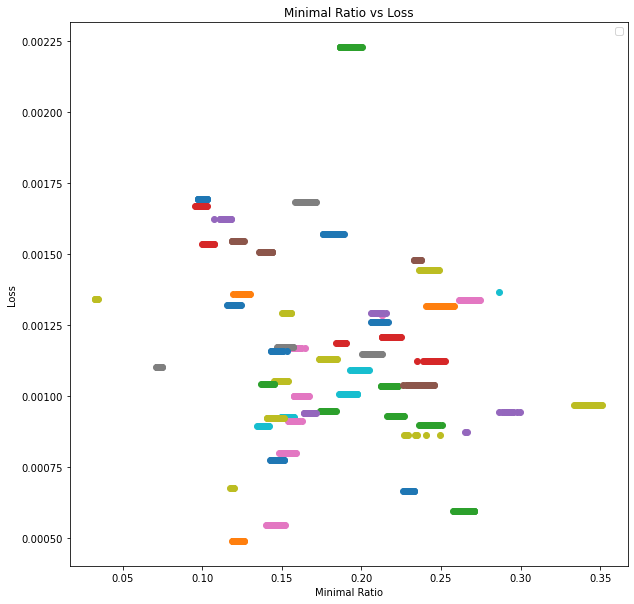

FileNotFoundError: [Errno 2] No such file or directory: './figs/2-minimal_ratio_vs_loss.png'

In [24]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.main(x)

def train_first_stage(model, train_loader, optimizer, criterion, epochs=1000):
    model.train()
    losses = []
    gradients = []
    minimal_ratios = []
    progress_bar = tqdm(range(epochs))
    for epoch in progress_bar:
        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        progress_bar.set_description(f'Epoch: {epoch+1}/{epochs}')
    return losses, gradients, minimal_ratios

def epoch_loss(model, criterion, train_loader):
    with torch.no_grad():
        model.eval()
        losses = []
        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            losses.append(loss.item())
        model.train()
    return sum(losses) / len(losses)


def train_second_stage(model, train_loader, optimizer, criterion, epochs=1000):
    model.train()
    losses = []
    gradients = []
    minimal_ratios = []
    progress_bar = tqdm(range(epochs))

    names = list(n for n, _ in model.named_parameters())
    def loss_hessian(params):
        y_hat = torch.func.functional_call(model, {n: p for n, p in zip(names, params)}, x)
        return criterion(y_hat, y)
    
    def closure():
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        return loss

    for epoch in progress_bar:
        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            # optimizer.zero_grad()
            optimizer.step(closure)

        # Calculate gradient norm
        gradient = torch.cat([p.grad.flatten() for p in model.parameters()])
        gradient_norm = torch.norm(gradient, 2)
        if gradient_norm < 1e-2:
            losses.append(epoch_loss(model, criterion, train_loader))
            gradients.append(gradient_norm.item())
            hessian = torch.func.hessian(loss_hessian)(tuple(model.parameters()))
            num_pos_eig = 0
            num_all_eig = 0
            for hi in hessian:
                for tensor in hi:
                    # if not batches of square matrices, continue
                    if tensor.size(-1) != tensor.size(-2):
                        continue
                    eigenvalues = torch.linalg.eigvals(tensor)
                    positive_eigenvalues = (eigenvalues.real > 0).sum()
                    num_pos_eig += positive_eigenvalues
                    num_all_eig += eigenvalues.nelement()
            minimal_ratio = num_pos_eig / num_all_eig
            minimal_ratios.append(minimal_ratio.item())
            

        progress_bar.set_description(f'Epoch: {epoch+1}/{epochs}')

    return losses, gradients, minimal_ratios

if __name__ == "__main__":
    # Create the data
    x = torch.linspace(-10, 10, 10000).reshape(-1, 1)
    y = torch.sin(2 * torch.pi * x) / (2 * torch.pi * x)

    # parameters
    train_loader = torch.utils.data.DataLoader(list(zip(x, y)), batch_size=2000, shuffle=True)
    lr = 1e-3
    criterion = nn.MSELoss()
    epochs = 750

    repeat = 100
    all_losses = []
    all_minimum_ratios = []
    for i in range(repeat):
        model = DNN().to(device)
        optimizer1 = torch.optim.AdamW(model.parameters(), lr=lr)
        optimizer2 = torch.optim.LBFGS(model.parameters(), lr=lr, history_size=5)
        # train the model with original criterion for 700 epochs
        _, _, _ = train_first_stage(model, train_loader, optimizer1, criterion, epochs)
        losses, gradients, minimal_ratio = train_second_stage(model, train_loader, optimizer2, criterion, epochs) 
        print(f'loss: {losses}, gradient: {gradients}, minimal_ratio: {minimal_ratio}')
        # sample 100 points from the losses
        if len(losses) > 100:
            indices = np.random.choice(len(losses), 100, replace=False)
            losses = np.array(losses)[indices]
            minimal_ratio = np.array(minimal_ratio)[indices]
        else:
            losses = np.array(losses)
            minimal_ratio = np.array(minimal_ratio)
        all_losses.append(losses)
        all_minimum_ratios.append(minimal_ratio)

    figure = plt.figure(figsize=(10, 10))
    # plot the minimal ratio and losses as points
    for i in range(repeat):
        plt.scatter(all_minimum_ratios[i], all_losses[i])
    plt.xlabel('Minimal Ratio')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Minimal Ratio vs Loss')
    plt.show() 
    figure.savefig('./figs/2-minimal_ratio_vs_loss.png')



In [28]:
figure.savefig('2-minimal_ratio_vs_loss.png')


In [ ]:
plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


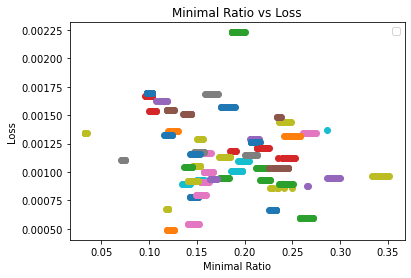

In [29]:
for i in range(repeat):
    plt.scatter(all_minimum_ratios[i], all_losses[i])
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')
plt.legend()
plt.title('Minimal Ratio vs Loss')
plt.show() 